In [27]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud


from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset, DataLoader
from string import punctuation
import csv
from nltk.tokenize import word_tokenize
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


In [28]:
#class_names = ['negative','positive','neutral'] # Classification0
#class_names = ['negative','positive'] #Classification1,Movie_review
class_names = ['0','1','2','3','4'] #Classification2

In [30]:
def fun1(review):
    review = review.lower() # lowercase, standardize
    return ''.join([c for c in review if c not in punctuation])

def fun2(x):
    if x=='negative':
        return 0
    elif x=='positive':
        return 1
    else:
        return 2

# Classification0,2 are imbalanced

#df = pd.read_excel('ClassificationDataset2.xlsx',names = ['sentiment','review']) # classification2
#df = pd.read_excel('ClassificationDataset0.xlsx',names=['sentiment','review'],header = None) #Classification0
#df = pd.read_csv('all-data.csv',encoding="ISO-8859-1",names=['sentiment','review'],header = None) # all-data
df = pd.read_csv('/home/manikanta/NLP/Ass_2/Hierarchical-attention-networks-pytorch/ClassificationDataset1_new.csv') # ../../Sentiment_classification(Movie_reviews)/train.csv, Classification1_new.csv

df = df.dropna()
df = df.sample(frac=1) # shuffles the data

# get rid of punctuation
df['review'] = df['review'].apply(fun1)
#df['sentiment'] = df['sentiment'].apply(fun2)  # Classification0,all_data
#df['sentiment'] = df['sentiment'].apply(lambda x: x-1) # classification2
df.head()

,review,sentiment
4713,the room size was smalle the temperature in ro...,0
3250,your beautiful garden,1
7006,beautifully kept large sized garden with sepa...,1
1585,we ended up staying at the paddington hotel a...,1
14374,i booked a deluxe twin room as per the photos ...,0


In [31]:
df.shape

(17998, 2)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

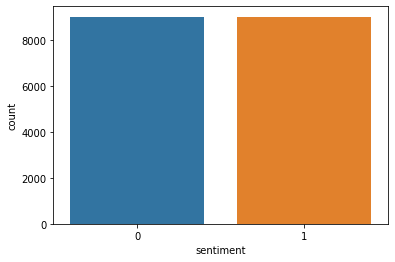

In [32]:
sns.countplot(data = df, x = 'sentiment')

In [33]:
df['total_words'] = df['review'].apply(lambda x: len(x.split(' ')))
sns.displot(df,x = 'total_words',bins = 50)

AttributeError: module 'seaborn' has no attribute 'displot'

In [34]:
print("Min = ",df['total_words'].min())
print("Max = ",df['total_words'].max())
print("Mean = ",df['total_words'].mean())

Min =  2
Max =  395
Mean =  20.051172352483608


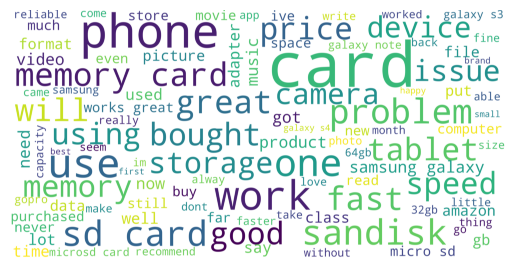

In [15]:
# Most frequent words
word_cloud_text = ''.join(df['review'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [16]:

class MyDataset(Dataset):

    # fold range 0,1..(n_folds-1)
    def __init__(self, df, dict_path, n_folds = 1,leave_out_fold = 0,split = 'train', max_length_sentence=200):
        super(MyDataset, self).__init__()

        texts = list(df['review'].values)
        labels = list(df['sentiment'].values)
        
        if n_folds == 1:
            # 80-20 split
            if split == 'train':
                X,Y = texts[:int(len(texts)*0.8)], labels[:int(len(texts)*0.8)]
            else:
                X,Y = texts[int(len(texts)*0.8):], labels[int(len(texts)*0.8):]
        else:
            each_fold = int(len(texts)/n_folds) 
            if split == 'train':
                print(leave_out_fold*each_fold)
                X_l,Y_l = texts[: leave_out_fold*each_fold ], labels[: leave_out_fold*each_fold ]
                X_r,Y_r = texts[(leave_out_fold+1)*each_fold:], labels[(leave_out_fold+1)*each_fold :]
                X_l.extend(X_r)
                Y_l.extend(Y_r)
                X = X_l
                Y = Y_l
            else:
                X,Y = texts[leave_out_fold*each_fold: (leave_out_fold+1)*each_fold ], labels[leave_out_fold*each_fold : (leave_out_fold+1)*each_fold ]

        self.X = X
        self.Y = Y
        
        self.words = pd.read_csv(filepath_or_buffer=dict_path, header=None, sep=" ", quoting=csv.QUOTE_NONE,
                                usecols=[0]).values
        

        self.dict = {}
        self.int_to_word = {}
        # use index 0 for <unk> token
        # use index 1 for <pad> token
        for i,word in enumerate(self.words):
            self.dict[word[0]] = i+2
            self.int_to_word[i+2] = word[0]
        self.max_length_sentence = max_length_sentence
        self.num_classes = len(set(self.Y))

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        label = self.Y[index]
        text = self.X[index]                                   #<unk> 
        text_encode = [self.dict[word] if word in self.dict else 0 for word in word_tokenize(text=text)]
        text_encode = text_encode[:self.max_length_sentence]
        if(len(text_encode) < self.max_length_sentence):
            for _ in range(self.max_length_sentence - len(text_encode)):
                text_encode.append(1) # <pad>

        text_encode = torch.LongTensor(text_encode)

        return text_encode,label
        



In [18]:
glove_path = '/data4/home/manikantab/Diffusion_models/NLP/Hierarchical-attention-networks-pytorch/data/glove.6B.50d.txt'
#glove_path = '../glove.42B.300d.txt'


train_data = MyDataset(df,glove_path,split='train')
val_data = MyDataset(df,glove_path,split='val')

print("Train data size == ",len(train_data))
print("Val data size == ",len(val_data))

Train data size ==  3198
Val data size ==  800


In [19]:
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [20]:
from collections import Counter
Counter(train_data.Y)

Counter({4: 2556, 3: 347, 0: 162, 1: 49, 2: 84})

In [21]:
Counter(val_data.Y)

Counter({4: 647, 1: 13, 0: 32, 3: 86, 2: 22})

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_dtype(torch.float64)

class DAN(nn.Module):
    def __init__(self,word2vec_path,hidden1_size = 100,hidden2_size = 100,hidden3_size = 100,num_classes = 3):
        super(DAN,self).__init__()

        dict = pd.read_csv(filepath_or_buffer=word2vec_path, header=None, sep=" ", quoting=csv.QUOTE_NONE).values[:, 1:]
        dict_len, embed_size = dict.shape
        dict_len += 2
        # index 0 for <unk>
        # index 1 for <pad>
        unk_pad = np.zeros((2, embed_size))
        dict = torch.from_numpy(np.concatenate([unk_pad, dict], axis=0).astype(np.float64))

        self.lookup = nn.Embedding(num_embeddings=dict_len, embedding_dim=embed_size).from_pretrained(dict)
        #self.lookup = nn.Embedding(num_embeddings=dict_len, embedding_dim=embed_size)
        self.fc1 = nn.Linear(embed_size,hidden1_size)
        self.fc2 = nn.Linear(hidden1_size,hidden2_size)
        self.fc3 = nn.Linear(hidden2_size,hidden3_size)


        self.output = nn.Linear(hidden3_size,num_classes)


    def forward(self,X):
        # X.shape = (batch_size,seq_length)
        embed = self.lookup(X) # (batch_size,seq_length,embed_size)
        av = torch.mean(embed,dim = 1)  #(batch_size,embed_size)
        h1 = self.fc1(av) #(batch_size,hidden1_size)
        h1 = F.relu(h1)
        h2 = self.fc2(h1) #(batch_size,hidden2_size)
        h2 = F.relu(h2)
        h3 = self.fc3(h2) #(batch_size,hidden3_size)
        h3 = F.relu(h3)
        o = self.output(h3) # (batch_size,num_classes)

        return o
    
    

In [23]:
model = DAN(glove_path,num_classes=len(class_names))
train_iter = train_loader.__iter__()
X,Y = next(train_iter)
model(X).shape

torch.Size([64, 5])

In [24]:
device = 'cuda:4'
model = model.to(device)
criterion = nn.CrossEntropyLoss()

model.lookup.weight.requires_grad = True
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.05)
num_epochs = 5

model.train()

num_iter_per_epoch = len(train_loader)
for epoch in range(num_epochs):
    for iter, (feature, label) in enumerate(train_loader):
        feature = feature.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        predictions = model(feature) # shape = (batch_size, num_classes)
        loss = criterion(predictions, label) # It implicitly calculated the softmax on predictions
        loss.backward()
        optimizer.step()
        
    if epoch%1 == 0:
        model.eval()
        num_correct = 0

        total_pred = []
        total_correct = []
        for feature,labels in valid_loader:
            feature = feature.to(device)
            labels = labels.to(device)

            pred = model(feature)

            pred = pred.softmax(dim = 1).argmax(dim = 1)

            total_pred.extend(list(pred.cpu().numpy()))
            total_correct.extend(list(labels.cpu().numpy()))
            # compare predictions to true label
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())

            num_correct+=np.sum(correct)
            
        model.train()
        print("Epoch: {}/{}, Iteration: {}/{}, Lr: {}, Loss: {}, ValAccuracy: {}".format(
                    epoch + 1,
                    num_epochs,
                    iter + 1,
                    num_iter_per_epoch,
                    optimizer.param_groups[0]['lr'],
                    loss,num_correct/len(val_data)))


Epoch: 1/5, Iteration: 50/50, Lr: 0.05, Loss: 0.5774692258915005, ValAccuracy: 0.8125
Epoch: 2/5, Iteration: 50/50, Lr: 0.05, Loss: 0.5732300322030308, ValAccuracy: 0.79625
Epoch: 3/5, Iteration: 50/50, Lr: 0.05, Loss: 0.5264482201491483, ValAccuracy: 0.81125
Epoch: 4/5, Iteration: 50/50, Lr: 0.05, Loss: 0.38598925062923517, ValAccuracy: 0.81625
Epoch: 5/5, Iteration: 50/50, Lr: 0.05, Loss: 0.27240676499883626, ValAccuracy: 0.82375


In [27]:
model.eval()
num_correct = 0

total_pred = []
total_correct = []
for feature,labels in valid_loader:
    feature = feature.to(device)
    labels = labels.to(device)

    pred = model(feature)

    pred = pred.softmax(dim = 1).argmax(dim = 1)

    total_pred.extend(list(pred.cpu().numpy()))
    total_correct.extend(list(labels.cpu().numpy()))
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())

    num_correct+=np.sum(correct)
print("Accuracy == ",num_correct/len(val_data))



Accuracy ==  0.82375


In [28]:
print(classification_report(total_correct, total_pred,target_names=class_names))

macroF1 = f1_score(total_correct, total_pred, average='macro')
microF1 = f1_score(total_correct, total_pred, average='micro')

print("\n------------- Micro F1 Score == {} ------------".format(microF1))
print("------------- Macro F1 Score == {} ------------\n".format(macroF1))

              precision    recall  f1-score   support

           0       0.64      0.56      0.60        32
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        22
           3       0.22      0.08      0.12        86
           4       0.86      0.98      0.91       647

    accuracy                           0.82       800
   macro avg       0.34      0.32      0.33       800
weighted avg       0.74      0.82      0.78       800


------------- Micro F1 Score == 0.82375 ------------
------------- Macro F1 Score == 0.3265694768614129 ------------



/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_